In [6]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from tld import get_tld, is_tld

In [7]:
data = pd.read_csv('/Users/taylorhurt/Desktop/CIDM_6341_cybersecurity/malicious_phish.csv',index_col=False)
data['type']=data['type'].astype('category')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   url     651191 non-null  object  
 1   type    651191 non-null  category
dtypes: category(1), object(1)
memory usage: 5.6+ MB
None


url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

In [8]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://garage-pirenne.be/index.php?option=com_...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188             gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190              angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]

In [9]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

In [10]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [11]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [12]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [13]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [14]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [15]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

In [16]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [17]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

In [18]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [19]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [20]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [21]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [22]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [23]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

In [24]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [25]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [26]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [28]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [29]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,SGDClassifier,
          ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    print('\033[31m###################- End -###################\033[0m')

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  90.93%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85565
           1       0.93      0.96      0.95     19319
           2       0.80      0.57      0.66     18805
           3       0.94      0.91      0.93      6550

    accuracy                           0.91    130239
   macro avg       0.90      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239

             Confusion_matrix 
###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  91.51%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1  

In [30]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})

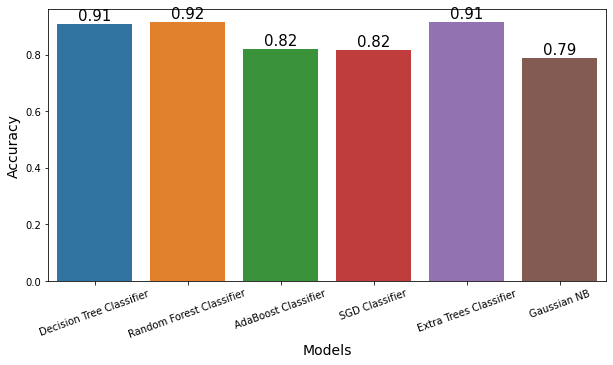

In [31]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [32]:
from imblearn.over_sampling import SMOTE
method = SMOTE(random_state=2)
X_resampled, y_resampled = method.fit_resample(X,y)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resampled,y_resampled, stratify=y_resampled, test_size = .2, shuffle=True,random_state = 5)

In [33]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,SGDClassifier,
          ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('SMOTE Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train_r, y_train_r)
    pred = model_.predict(X_test_r)
    acc = accuracy_score(pred, y_test_r)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test_r, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    print('\033[31m###################- End -###################\033[0m')

#############################################
SMOTE Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  89.92%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     85620
           1       0.94      0.98      0.96     85621
           2       0.81      0.84      0.82     85621
           3       0.98      0.95      0.96     85621

    accuracy                           0.90    342483
   macro avg       0.90      0.90      0.90    342483
weighted avg       0.90      0.90      0.90    342483

             Confusion_matrix 
###################- End -###################
#############################################
SMOTE Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  90.21%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.87      0.84      0.86     85620
           1    

In [34]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})

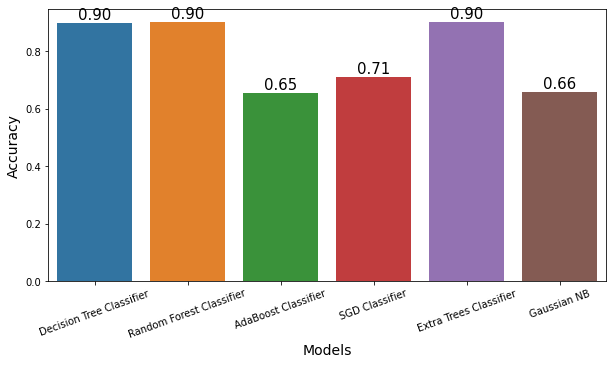

In [35]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()